Currently:
* training the original network (500-500-2000-2) on mnist with tsne loss
* training the original network on a pre-embedded set of 2d points with mse loss
* training a convolution net on a pre-embedded set of 2d points with mse loss

Next:
* check tsne loss on test set for all three models
* if we lower the learning rate in response to test set loss can we acheive lower final loss?
* what architecture allows us to minimize the number of parameters while also minimizing test tsne loss?
* does dropout have an effect on the generalization of any of the models?
* can we "deep dream" a point in 2d space to recover an input that produces it?
* what happens if we permute the input data but use the same joint probabilities?
* what if we instead use P from an unsupervised mid-dimensional representation like an autoencoder or VAE? (e.g., 48D)
* what if we use t-SNE loss as a contributing cost function to an autoencoder?

In [1]:
# !nvidia-smi

In [2]:
# import os
# os.environ['THEANO_FLAGS'] = 'device=gpu1'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
batch_size = 5000

%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

CPU times: user 768 ms, sys: 52 ms, total: 820 ms
Wall time: 831 ms
(60000, 'train samples')
(10000, 'test samples')


In [4]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [5]:
%time P = compute_joint_probabilities(X_train, batch_size=batch_size, verbose=2)

Precomputing P-values...
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.21039589672
Minimum value of sigma: 1.14651898224
Maximum value of sigma: 3.42356224164
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...

In [6]:
%time np.save('P.npy', P)
# %time P = np.load('P.npy')

CPU times: user 0 ns, sys: 1.31 s, total: 1.31 s
Wall time: 2.59 s


In [7]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
#     d = K.shape(activations)[1]
    d = 2 # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [8]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))
sgd = SGD(lr=0.1)
%time model.compile(loss=tsne, optimizer=sgd)

CPU times: user 140 ms, sys: 76 ms, total: 216 ms
Wall time: 221 ms


In [9]:
Y_train = P.reshape(X_train.shape[0], -1)
print(P.shape)
print(X_train.shape)
print(Y_train.shape)

(12, 5000, 5000)
(60000, 784)
(60000, 5000)


In [11]:
%time model.fit(X_train, Y_train, batch_size=batch_size, shuffle=False, nb_epoch=100)

Epoch 1/100
60000/60000 [==============================] - 1s - loss: 4.8259     
Epoch 2/100
60000/60000 [==============================] - 1s - loss: 3.9386     
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 3.6038     
Epoch 4/100
60000/60000 [==============================] - 1s - loss: 3.5036     
Epoch 5/100
60000/60000 [==============================] - 1s - loss: 3.4470     
Epoch 6/100
60000/60000 [==============================] - 1s - loss: 3.4056     
Epoch 7/100
60000/60000 [==============================] - 1s - loss: 3.3704     
Epoch 8/100
60000/60000 [==============================] - 1s - loss: 3.3379     
Epoch 9/100
60000/60000 [==============================] - 1s - loss: 3.3066     
Epoch 10/100
60000/60000 [==============================] - 1s - loss: 3.2763     
Epoch 11/100
60000/60000 [==============================] - 1s - loss: 3.2471     
Epoch 12/100
60000/60000 [==============================] - 1s - loss: 3.2189     
Epoch 13/100


In [10]:
def plot_model(embedding, labels):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='', c=labels)
    fig.tight_layout()
    
from matplotlib.lines import Line2D
def plot_differences(embedding, actual, lim=1000):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    for a, b in zip(embedding, actual)[:lim]:
        ax.add_line(Line2D((a[0], b[0]), (a[1], b[1]), linewidth=1))
    ax.autoscale_view()
    plt.show()
# plot_model(model.predict(data), y_train)

In [11]:
from tsne import bh_sne
%time X_2d = bh_sne(X_train.astype(np.float64))

CPU times: user 17min 40s, sys: 2.1 s, total: 17min 42s
Wall time: 17min 36s


In [16]:
%time np.save('X_2d.npy', X_2d)
# %time X_2d = np.load('X_2d.npy')
X_2d.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 576 µs


(60000, 2)

In [13]:
# around 1.2M parameters
encoder = Sequential()
encoder.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
encoder.add(Dense(500, activation='relu'))
encoder.add(Dense(2000, activation='relu'))
encoder.add(Dense(2))
%time encoder.compile(loss='mse', optimizer='rmsprop')

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 48.7 ms


In [14]:
%time encoder.fit(X_train, X_2d, nb_epoch=100, verbose=2)

Epoch 1/100
6s - loss: 22.3851
Epoch 2/100
5s - loss: 10.0744
Epoch 3/100
5s - loss: 7.3003
Epoch 4/100
5s - loss: 5.9253
Epoch 5/100
5s - loss: 4.9065
Epoch 6/100
5s - loss: 4.2567
Epoch 7/100
5s - loss: 3.7882
Epoch 8/100
5s - loss: 3.3375
Epoch 9/100
5s - loss: 3.0452
Epoch 10/100
5s - loss: 2.7005
Epoch 11/100
5s - loss: 2.4845
Epoch 12/100
5s - loss: 2.2809
Epoch 13/100
5s - loss: 2.1628
Epoch 14/100
5s - loss: 2.0034
Epoch 15/100
5s - loss: 1.8998
Epoch 16/100
5s - loss: 1.7829
Epoch 17/100
5s - loss: 1.7184
Epoch 18/100
5s - loss: 1.5792
Epoch 19/100
5s - loss: 1.5168
Epoch 20/100
5s - loss: 1.4608
Epoch 21/100
5s - loss: 1.4204
Epoch 22/100
5s - loss: 1.3495
Epoch 23/100
5s - loss: 1.3301
Epoch 24/100
5s - loss: 1.2713
Epoch 25/100
5s - loss: 1.2501
Epoch 26/100
5s - loss: 1.1367
Epoch 27/100
5s - loss: 1.1459
Epoch 28/100
5s - loss: 1.1096
Epoch 29/100
5s - loss: 1.0883
Epoch 30/100
5s - loss: 1.0486
Epoch 31/100
5s - loss: 1.0001
Epoch 32/100
5s - loss: 1.0217
Epoch 33/100
5s

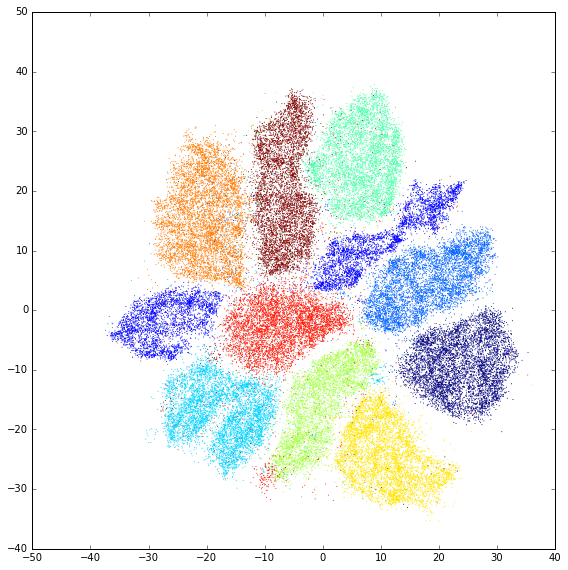

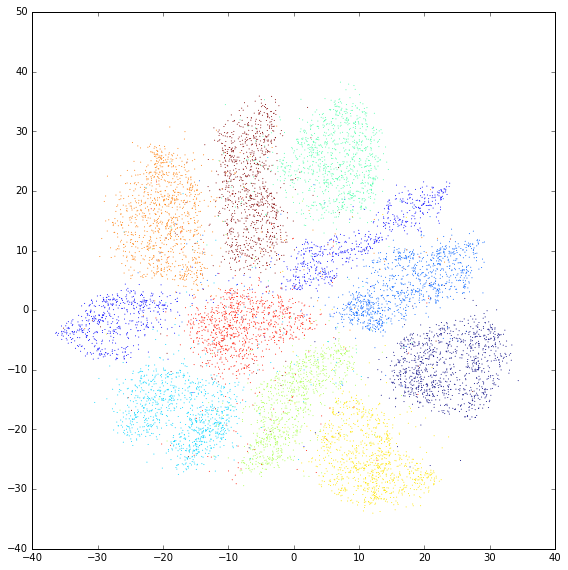

In [18]:
plot_model(encoder.predict(X_train), y_train)
plot_model(encoder.predict(X_test), y_test)
# plot_model(model.predict(X_train), y_train)

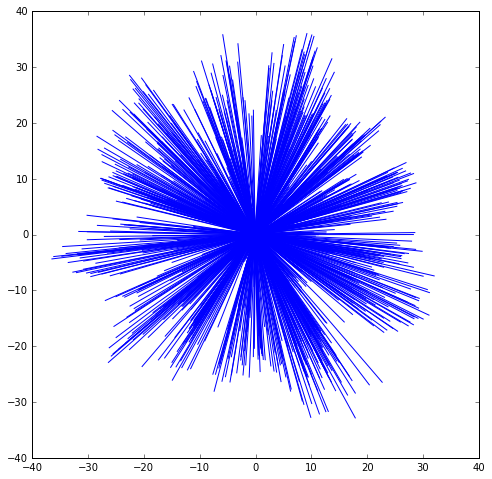

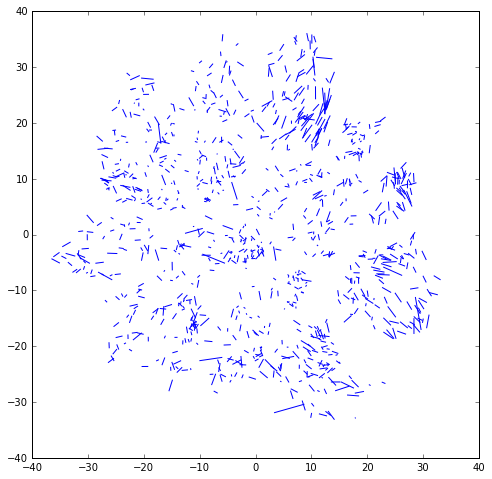

In [17]:
plot_differences(encoder.predict(X_train), model.predict(X_train))
plot_differences(encoder.predict(X_train), X_2d)

In [19]:
# around 600K parameters
nb_filters = 32
nb_pool = 2
nb_conv = 3
conv = Sequential()
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(28, 28, 1)))
conv.add(Activation('relu'))
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv))
conv.add(Activation('relu'))
conv.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
conv.add(Dropout(0.25))
conv.add(Flatten())
conv.add(Dense(128))
conv.add(Activation('relu'))
conv.add(Dense(2))
%time conv.compile(loss='mean_squared_error', optimizer='rmsprop')

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 87.8 ms


In [20]:
X_train_conv = X_train.reshape(-1, 28, 28, 1)
%time conv.fit(X_train_conv, X_2d, nb_epoch=100)

Epoch 1/100
60000/60000 [==============================] - 17s - loss: 27.2127    
Epoch 2/100
60000/60000 [==============================] - 17s - loss: 13.6133    
Epoch 3/100
60000/60000 [==============================] - 17s - loss: 11.4859    
Epoch 4/100
60000/60000 [==============================] - 17s - loss: 10.2989    
Epoch 5/100
60000/60000 [==============================] - 17s - loss: 9.5060    
Epoch 6/100
60000/60000 [==============================] - 17s - loss: 8.9053    
Epoch 7/100
60000/60000 [==============================] - 17s - loss: 8.4180    
Epoch 8/100
60000/60000 [==============================] - 17s - loss: 7.9720    
Epoch 9/100
60000/60000 [==============================] - 17s - loss: 7.6591    
Epoch 10/100
60000/60000 [==============================] - 17s - loss: 7.3897    
Epoch 11/100
60000/60000 [==============================] - 17s - loss: 7.1068    
Epoch 12/100
60000/60000 [==============================] - 17s - loss: 6.8380    
Epoch 13/

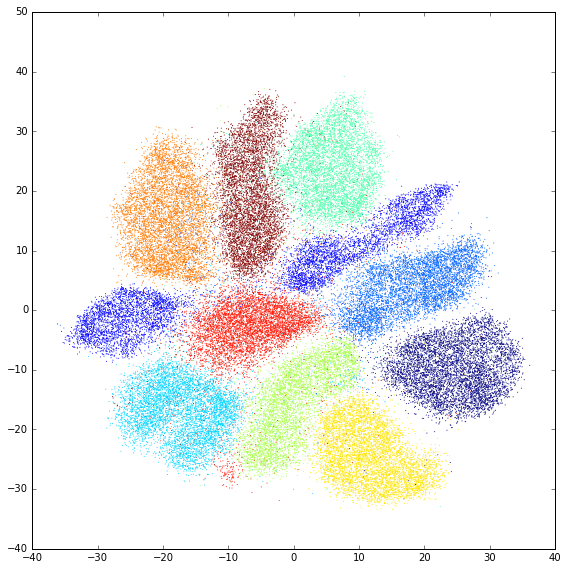

In [21]:
plot_model(conv.predict(X_train_conv), y_train)

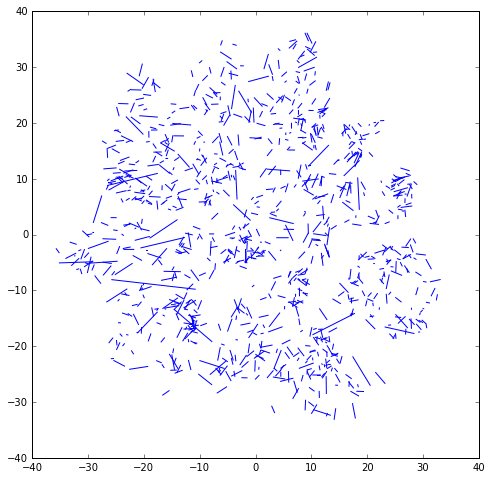

In [22]:
plot_differences(conv.predict(X_train_conv), X_2d)

In [23]:
# around 1.2M parameters
decoder = Sequential()
decoder.add(Dense(2000, activation='relu', input_shape=(2,)))
decoder.add(Dense(500, activation='relu'))
decoder.add(Dense(500, activation='relu'))
decoder.add(Dense(X_train.shape[1]))
%time decoder.compile(loss='mse', optimizer='rmsprop')

CPU times: user 240 ms, sys: 4 ms, total: 244 ms
Wall time: 239 ms


In [24]:
%time decoder.fit(X_2d, X_train, nb_epoch=100, verbose=2)

Epoch 1/100
6s - loss: 0.0449
Epoch 2/100
6s - loss: 0.0374
Epoch 3/100
6s - loss: 0.0360
Epoch 4/100
6s - loss: 0.0352
Epoch 5/100
6s - loss: 0.0347
Epoch 6/100
6s - loss: 0.0344
Epoch 7/100
6s - loss: 0.0341
Epoch 8/100
6s - loss: 0.0339
Epoch 9/100
6s - loss: 0.0337
Epoch 10/100
6s - loss: 0.0335
Epoch 11/100
6s - loss: 0.0333
Epoch 12/100
6s - loss: 0.0332
Epoch 13/100
6s - loss: 0.0331
Epoch 14/100
6s - loss: 0.0331
Epoch 15/100
6s - loss: 0.0330
Epoch 16/100
6s - loss: 0.0329
Epoch 17/100
6s - loss: 0.0328
Epoch 18/100
6s - loss: 0.0328
Epoch 19/100
6s - loss: 0.0327
Epoch 20/100
6s - loss: 0.0327
Epoch 21/100
6s - loss: 0.0327
Epoch 22/100
5s - loss: 0.0326
Epoch 23/100
6s - loss: 0.0326
Epoch 24/100
6s - loss: 0.0326
Epoch 25/100
6s - loss: 0.0326
Epoch 26/100
6s - loss: 0.0326
Epoch 27/100
6s - loss: 0.0326
Epoch 28/100
6s - loss: 0.0326
Epoch 29/100
6s - loss: 0.0326
Epoch 30/100
6s - loss: 0.0326
Epoch 31/100
6s - loss: 0.0326
Epoch 32/100
6s - loss: 0.0326
Epoch 33/100
6s -

In [25]:
def make_mosaic(images_flat, n):
    nx = ny = n
    w = h = int(np.sqrt(len(images_flat[0])))
    images = images_flat.reshape(-1, h, w)
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        for j in range(nx):
            mosaic[(nx-i-1)*w:(nx-i)*w, j*h:(j+1)*h] = next(image_gen)
    return mosaic

from cStringIO import StringIO
import PIL.Image
import IPython.display
import shutil
def showarray(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    if filename is not None:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

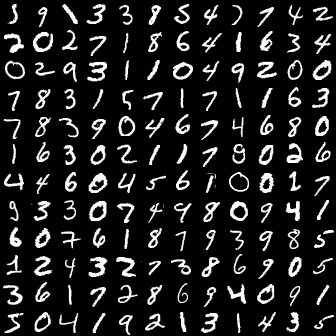

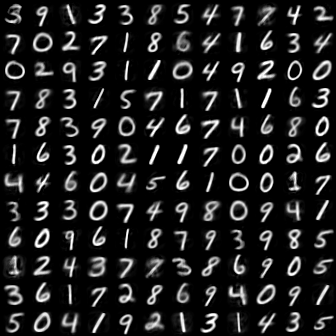

In [26]:
showarray(255 * make_mosaic(X_train, 12))
showarray(255 * make_mosaic(decoder.predict(X_2d), 12))

In [27]:
n = X_train.shape[1]
ae = Sequential()
ae.add(Dense(500, activation='relu', weights=encoder.layers[0].get_weights(), input_shape=(n,)))
ae.add(Dense(500, activation='relu', weights=encoder.layers[1].get_weights()))
ae.add(Dense(2000, activation='relu', weights=encoder.layers[2].get_weights()))
ae.add(Dense(2, weights=encoder.layers[3].get_weights()))
ae.add(Dense(2000, activation='relu', weights=decoder.layers[0].get_weights()))
ae.add(Dense(500, activation='relu', weights=decoder.layers[1].get_weights()))
ae.add(Dense(500, activation='relu', weights=decoder.layers[2].get_weights()))
ae.add(Dense(n, weights=decoder.layers[3].get_weights()))
%time ae.compile(loss='mse', optimizer='rmsprop')

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 186 ms


In [28]:
%time ae.fit(X_train, X_train, nb_epoch=100, verbose=2, batch_size=32)

Epoch 1/100
10s - loss: 0.0386
Epoch 2/100
10s - loss: 0.0389
Epoch 3/100
10s - loss: 0.0387
Epoch 4/100
10s - loss: 0.0386
Epoch 5/100
10s - loss: 0.0385
Epoch 6/100
10s - loss: 0.0386
Epoch 7/100
10s - loss: 0.0384
Epoch 8/100
10s - loss: 0.0383
Epoch 9/100
10s - loss: 0.0382
Epoch 10/100
10s - loss: 0.0381
Epoch 11/100
10s - loss: 0.0380
Epoch 12/100
10s - loss: 0.0380
Epoch 13/100
10s - loss: 0.0380
Epoch 14/100
10s - loss: 0.0381
Epoch 15/100
10s - loss: 0.0380
Epoch 16/100
10s - loss: 0.0377
Epoch 17/100
10s - loss: 0.0376
Epoch 18/100
10s - loss: 0.0376
Epoch 19/100
10s - loss: 0.0374
Epoch 20/100
10s - loss: 0.0376
Epoch 21/100
10s - loss: 0.0377
Epoch 22/100
10s - loss: 0.0373
Epoch 23/100
10s - loss: 0.0373
Epoch 24/100
10s - loss: 0.0373
Epoch 25/100
10s - loss: 0.0373
Epoch 26/100
10s - loss: 0.0374
Epoch 27/100
10s - loss: 0.0373
Epoch 28/100
10s - loss: 0.0372
Epoch 29/100
10s - loss: 0.0373
Epoch 30/100
10s - loss: 0.0373
Epoch 31/100
10s - loss: 0.0373
Epoch 32/100
10s 

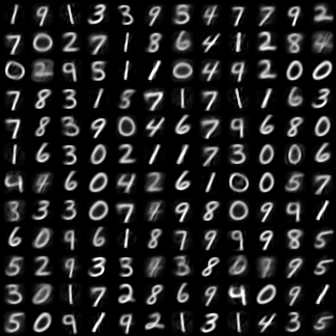

In [29]:
decoded = ae.predict(X_train)
showarray(255 * make_mosaic(decoded, 12))

In [44]:
import theano
def get_submodel(model, start, end):
    return theano.function([model.layers[start].input],
                          model.layers[end].get_output(train=False),
                          allow_input_downcast=True)
def get_encoder(ae):
    return get_submodel(ae, 0, (len(ae.layers) / 2) - 1)
def get_decoder(ae):
    return get_submodel(ae, len(ae.layers) / 2, (len(ae.layers) / 2) - 1) # this doesn't work

In [45]:
ae_encoder = get_encoder(ae)
ae_decoder = get_decoder(ae)

TypeError: 'Tensor' object is not callable

In [33]:
encoded = encoder.predict(X_train)
ae_encoded = ae.predict(X_train)

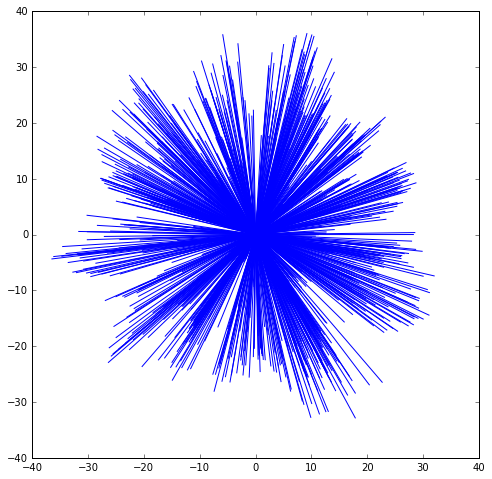

In [34]:
plot_differences(encoded, ae_encoded, lim=1000)

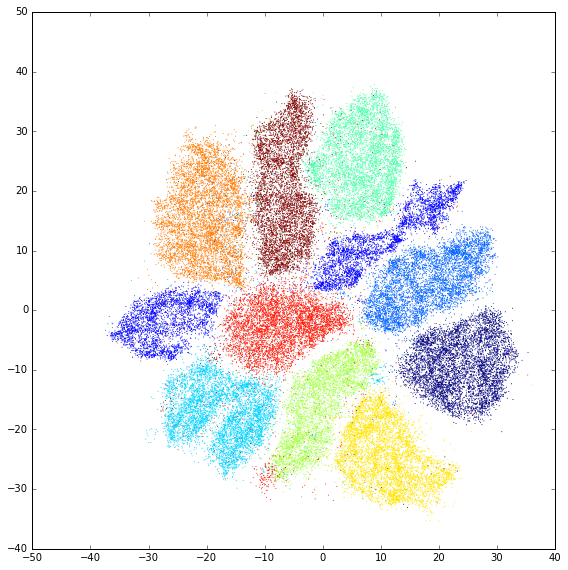

In [35]:
plot_model(encoded, y_train)

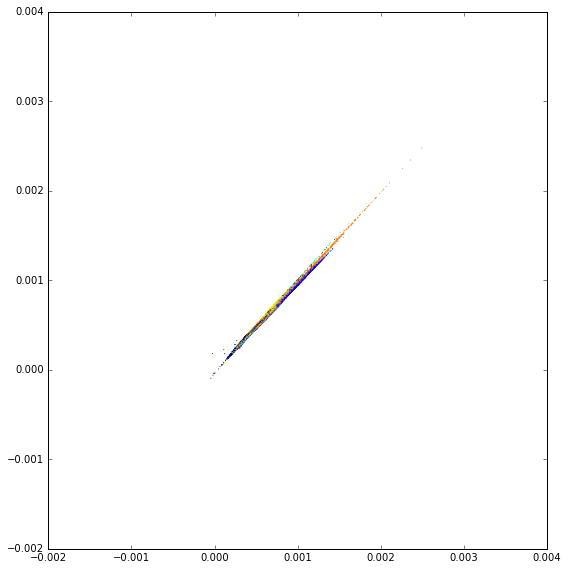

In [36]:
plot_model(ae_encoded, y_train)

In [37]:
ae_decoder = Sequential()
ae_decoder.add(Dense(2000, activation='relu', weights=ae.layers[4].get_weights(), input_shape=(2,)))
ae_decoder.add(Dense(500, activation='relu', weights=ae.layers[5].get_weights()))
ae_decoder.add(Dense(500, activation='relu', weights=ae.layers[6].get_weights()))
ae_decoder.add(Dense(X_train.shape[1], weights=ae.layers[7].get_weights()))
%time ae_decoder.compile(loss='mse', optimizer='rmsprop')

CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 259 ms


In [38]:
def sample_grid(model, example_data, filename=None, n=128):
    x = np.linspace(example_data[:,0].min(), example_data[:,0].max(), n)
    y = np.linspace(example_data[:,1].min(), example_data[:,1].max(), n)
    xv, yv = np.meshgrid(x, y)
    samples_encoded = np.array(zip(xv.flatten(), yv.flatten()))
    samples_decoded = model.predict(samples_encoded)
    showarray(255 * make_mosaic(samples_decoded, n), filename=filename)

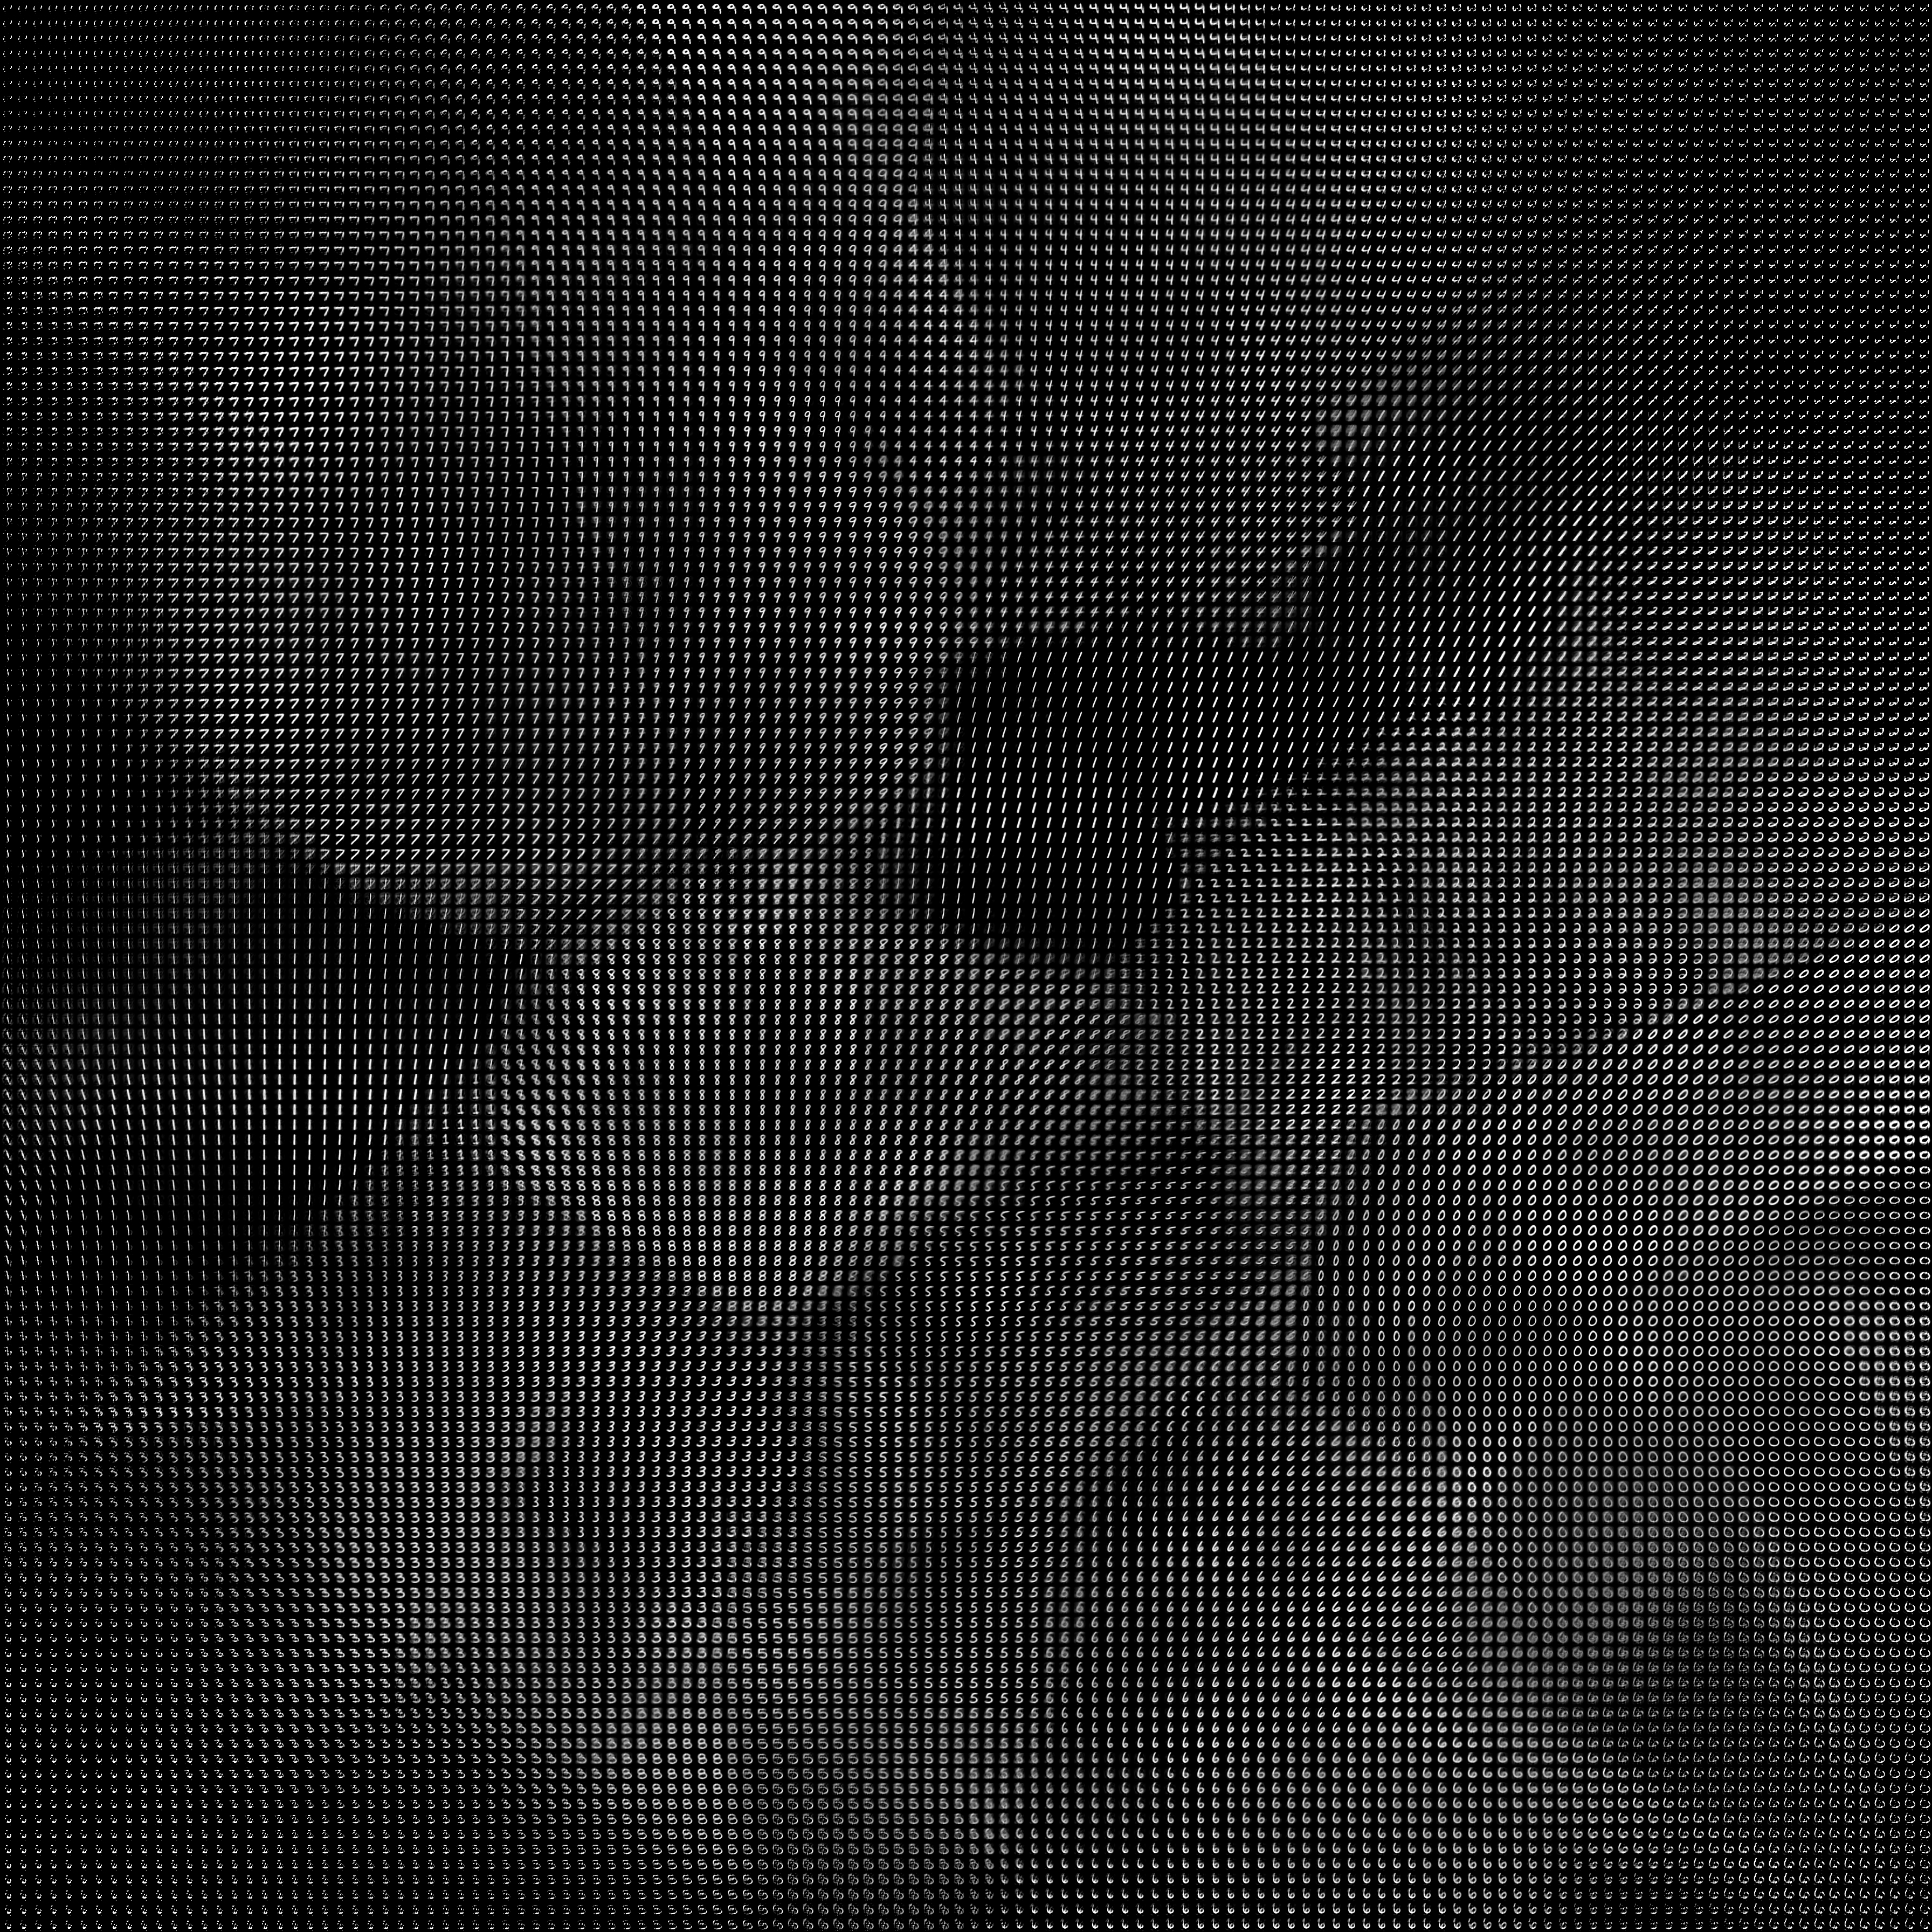

In [39]:
sample_grid(decoder, encoded, filename='output-orig.png')

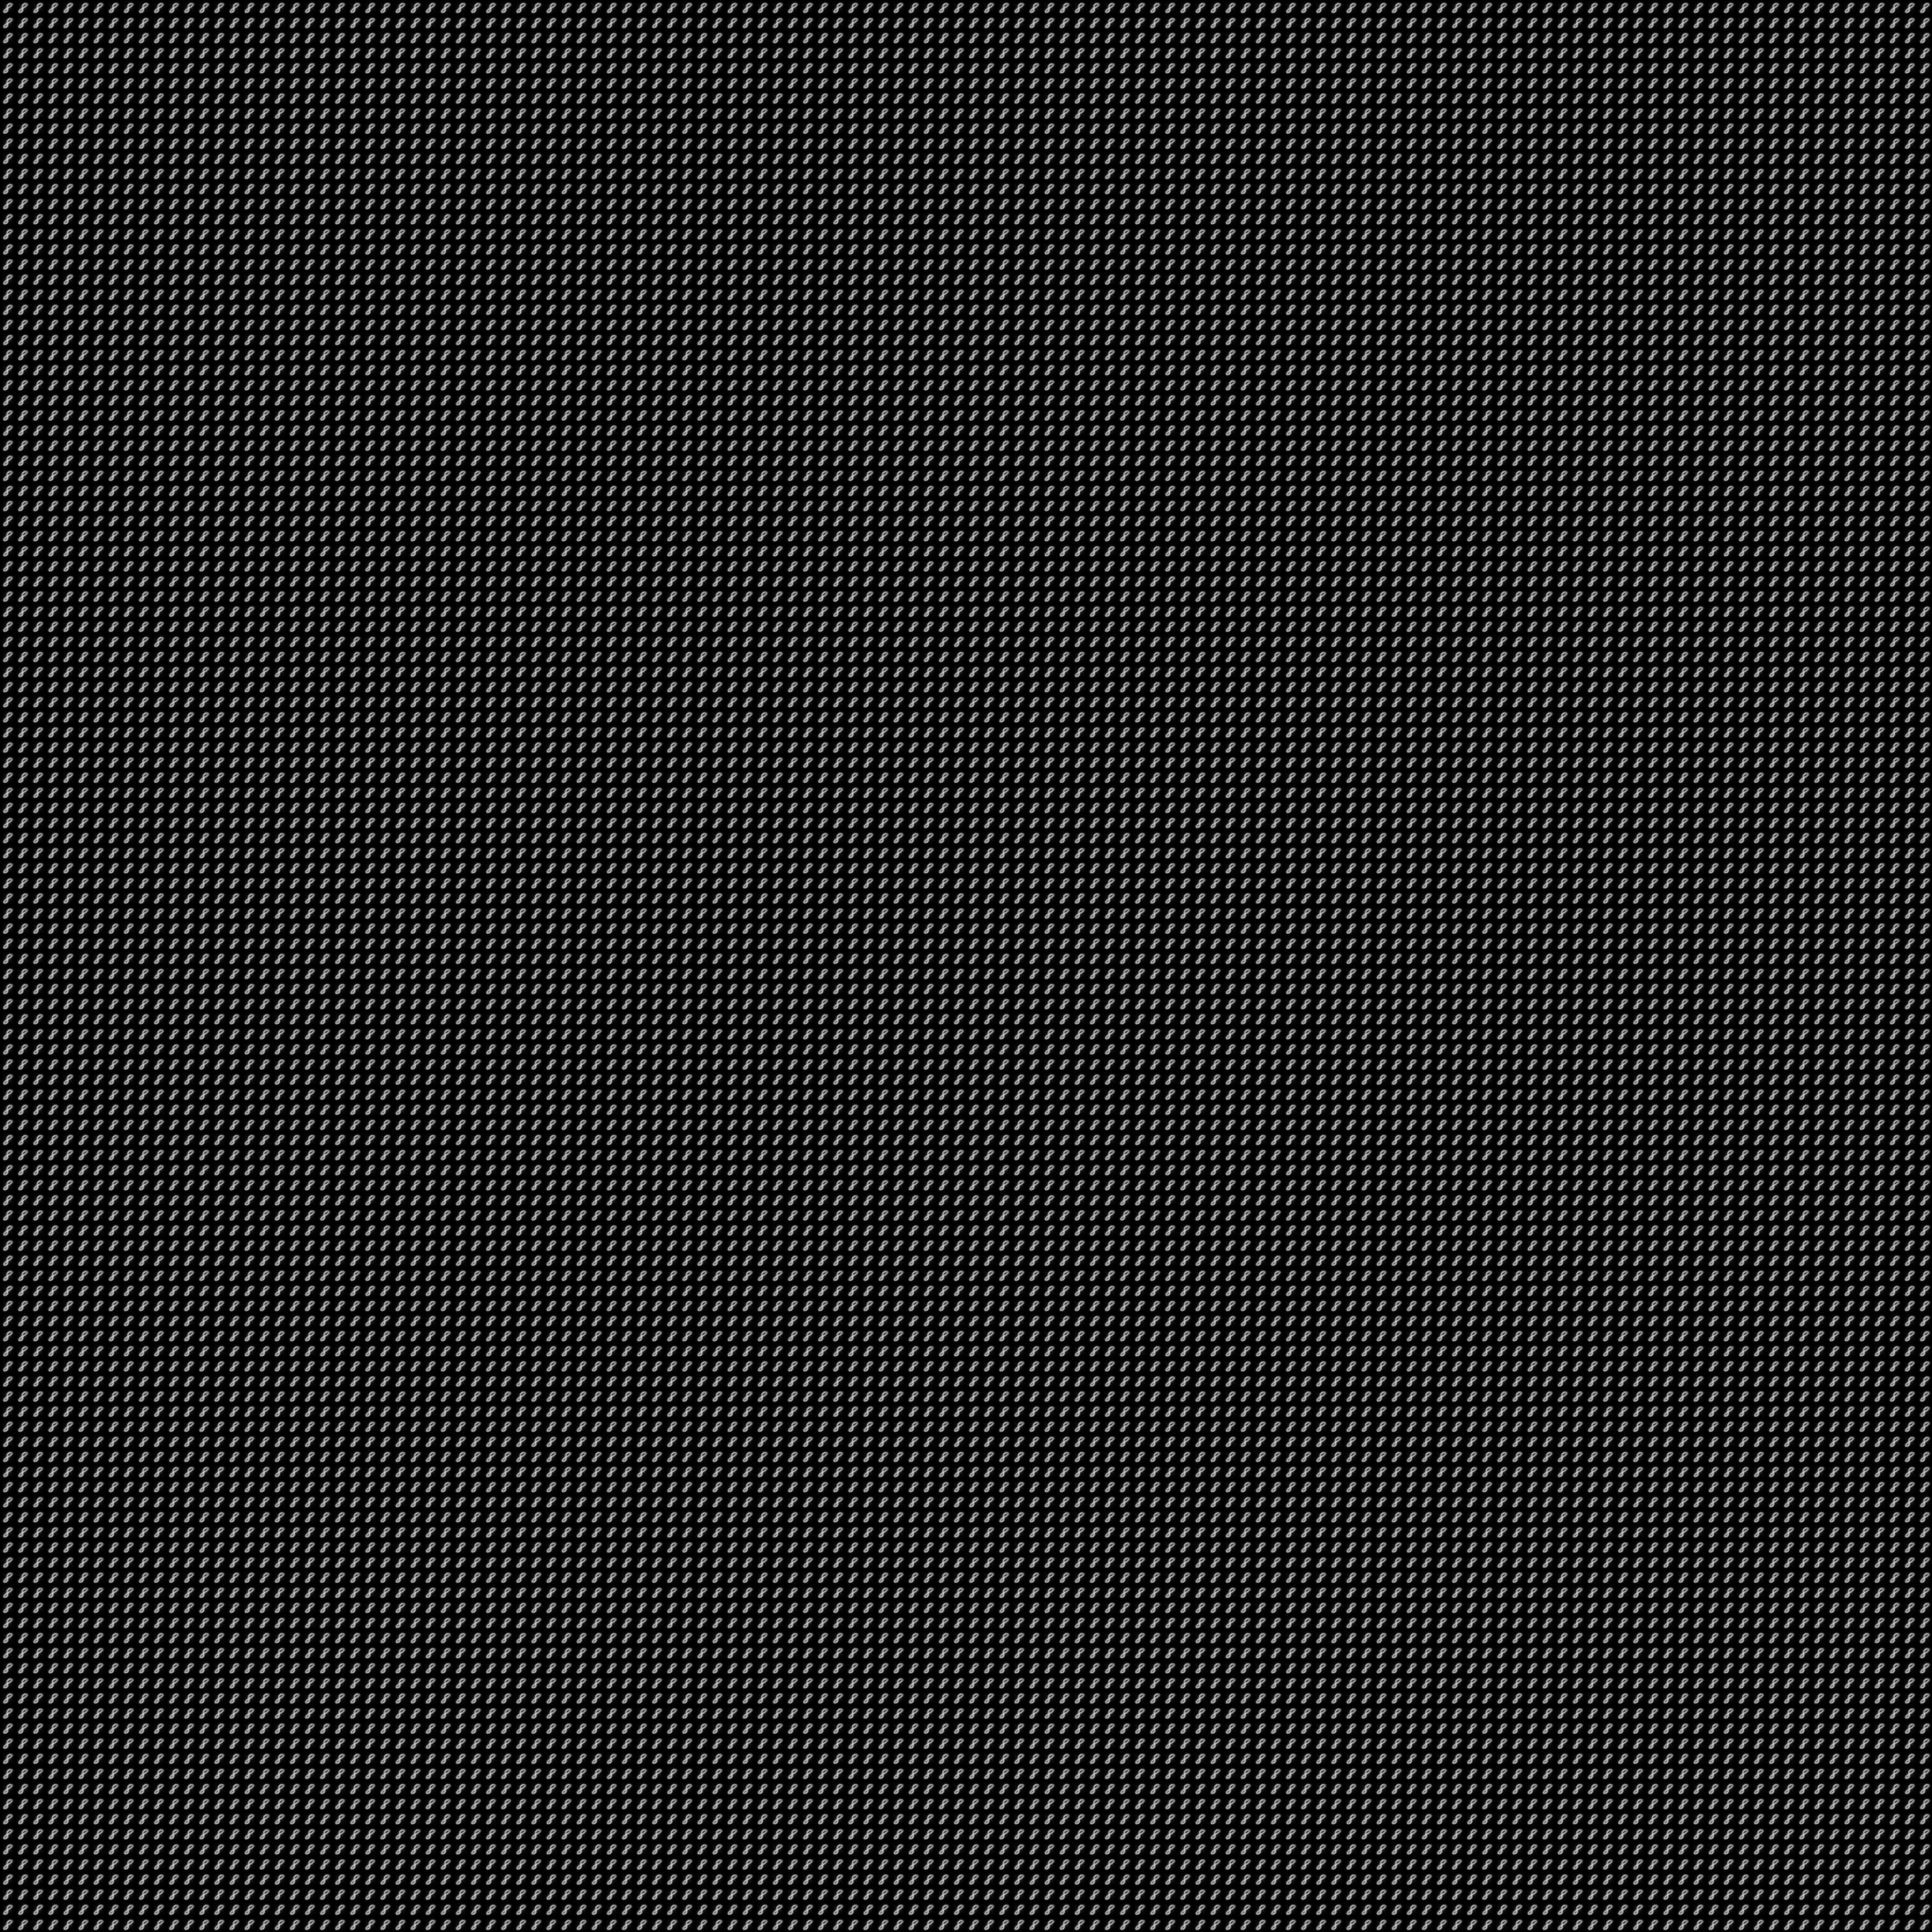

In [40]:
sample_grid(ae_decoder, ae_encoded, filename='output-finer.png')

In [41]:
n = X_train.shape[1]
ae_scratch = Sequential()
ae_scratch.add(Dense(500, activation='relu', input_shape=(n,)))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(2))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(n))
%time ae_scratch.compile(loss='mse', optimizer='rmsprop')

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 264 ms


In [42]:
ae_scratch.fit(X_train, X_train, nb_epoch=300, verbose=2)

Epoch 1/300
11s - loss: 0.0498
Epoch 2/300
10s - loss: 0.0417
Epoch 3/300
10s - loss: 0.0404
Epoch 4/300
10s - loss: 0.0395
Epoch 5/300
10s - loss: 0.0389
Epoch 6/300
10s - loss: 0.0381
Epoch 7/300
10s - loss: 0.0378
Epoch 8/300
10s - loss: 0.0373
Epoch 9/300
10s - loss: 0.0369
Epoch 10/300
10s - loss: 0.0366
Epoch 11/300
10s - loss: 0.0363
Epoch 12/300
10s - loss: 0.0362
Epoch 13/300
10s - loss: 0.0362
Epoch 14/300
10s - loss: 0.0360
Epoch 15/300
10s - loss: 0.0359
Epoch 16/300
10s - loss: 0.0358
Epoch 17/300
10s - loss: 0.0357
Epoch 18/300
10s - loss: 0.0357
Epoch 19/300
10s - loss: 0.0356
Epoch 20/300
10s - loss: 0.0356
Epoch 21/300
10s - loss: 0.0356
Epoch 22/300
10s - loss: 0.0355
Epoch 23/300
10s - loss: 0.0355
Epoch 24/300
10s - loss: 0.0355
Epoch 25/300
10s - loss: 0.0354
Epoch 26/300
10s - loss: 0.0355
Epoch 27/300
10s - loss: 0.0354
Epoch 28/300
10s - loss: 0.0354
Epoch 29/300
10s - loss: 0.0354
Epoch 30/300
10s - loss: 0.0355
Epoch 31/300
10s - loss: 0.0354
Epoch 32/300
10s 

In [43]:
plt.figure(figsize=(10,6))
plt1, = plt.plot(ae_scratch.history.history['loss'][:200], label='Vanilla AE')
plt2, = plt.plot(decoder.history.history['loss'], label='t-SNE Generator')
plt3, = plt.plot(range(100, 200), ae.history.history['loss'], label='t-SNE AE')
plt.legend(handles=[plt1, plt2, plt3])
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss (MSE)')
# plt.plot(encoder.history.history['loss'])

AttributeError: 'Sequential' object has no attribute 'history'

In [ ]:
ae_scratch_encoder = get_encoder(ae_scratch)

In [ ]:
ae_scratch_encoded = ae_scratch_encoder(X_train)

In [ ]:
ae_scratch_decoder = Sequential()
ae_scratch_decoder.add(Dense(2000, activation='relu', weights=ae_scratch.layers[4].get_weights(), input_shape=(2,)))
ae_scratch_decoder.add(Dense(500, activation='relu', weights=ae_scratch.layers[5].get_weights()))
ae_scratch_decoder.add(Dense(500, activation='relu', weights=ae_scratch.layers[6].get_weights()))
ae_scratch_decoder.add(Dense(X_train.shape[1], weights=ae_scratch.layers[7].get_weights()))
%time ae_scratch_decoder.compile(loss='mse', optimizer='rmsprop')

In [ ]:
sample_grid(ae_scratch_decoder, ae_scratch_encoded, filename='output-scratch.png')